Based on : https://machinelearningknowledge.ai/googlenet-architecture-implementation-in-keras-with-cifar-10-dataset/?utm_content=cmp-true


In [1]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim,padding="same"):
  input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
  input = BatchNormalization(axis=chanDim)(input)
  input = Activation("relu")(input)
  return input

In [3]:
def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim):
                                 #Step 1
  conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
                                 #Step 2
  conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
  conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
                                 #Step 3
  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
  pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
                                 #Step 4
  input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
  return input

In [4]:
def downsample_module(input,No_of_filters,chanDim):
  conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
  pool = MaxPooling2D((3,3),strides=(2,2))(input)
  input = concatenate([conv_3x3,pool],axis=chanDim)
  return input

In [5]:
def MiniGoogleNet(width,height,depth,classes):
  inputShape=(height,width,depth)
  chanDim=-1

  # (Step 1) Define the model input
  inputs = Input(shape=inputShape)

  # First CONV module
  x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)

  # (Step 2) Two Inception modules followed by a downsample module
  x = inception_module(x, 32, 32,32,32,chanDim)
  x = inception_module(x, 32, 48, 48,32,chanDim)
  x = downsample_module(x, 80, chanDim)
  
  # (Step 3) Five Inception modules followed by a downsample module
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = inception_module(x, 96, 64, 32,32,chanDim)
  x = inception_module(x, 80, 80, 32,32,chanDim)
  x = inception_module(x, 48, 96, 32,32,chanDim)
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = downsample_module(x, 96, chanDim)

  # (Step 4) Two Inception modules followed
  x = inception_module(x, 176, 160,96,96, chanDim)
  x = inception_module(x, 176, 160, 96,96,chanDim)
  
  # Global POOL and dropout
  x = AveragePooling2D((7, 7))(x)
  x = Dropout(0.5)(x)

  # (Step 5) Softmax classifier
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation("softmax")(x)

  # Create the model
  model = Model(inputs, x, name="googlenet")
  return model

In [6]:
NUM_EPOCHS = 30
INIT_LR = 5e-3
def poly_decay(epoch):
  maxEpochs = NUM_EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

In [7]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")
                                # Step 1
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean
                                # Step 2
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
                                # Step 3
aug = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1, horizontal_flip=True,fill_mode="nearest")

170498071/170498071 [==============================] - 14s 0us/step


In [8]:
callbacks=[LearningRateScheduler(poly_decay)]
opt = SGD(learning_rate=INIT_LR, momentum=0.9)
model = MiniGoogleNet(width=32, height=32, depth=3, classes=10)
                                    # Step 1
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
                                    # Step 2
# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))

history = model.fit(aug.flow(trainX, trainY, batch_size=64),validation_data=(testX, testY), steps_per_epoch=len(trainX) // 64,epochs=NUM_EPOCHS, callbacks=callbacks, verbose=1)

# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training started at %s Mon May  8 23:13:49 2023
Epoch 1/30
781/781 [==============================] - 135s 154ms/step - loss: 1.3774 - accuracy: 0.5016 - val_loss: 1.2852 - val_accuracy: 0.5515 - lr: 0.0050
Epoch 2/30
781/781 [==============================] - 117s 149ms/step - loss: 0.9248 - accuracy: 0.6745 - val_loss: 0.9063 - val_accuracy: 0.6827 - lr: 0.0048
Epoch 3/30
781/781 [==============================] - 117s 150ms/step - loss: 0.7448 - accuracy: 0.7408 - val_loss: 0.7390 - val_accuracy: 0.7416 - lr: 0.0047
Epoch 4/30
781/781 [==============================] - 117s 150ms/step - loss: 0.6432 - accuracy: 0.7777 - val_loss: 1.0203 - val_accuracy: 0.6860 - lr: 0.0045
Epoch 5/30
781/781 [==============================] - 117s 150ms/step - loss: 0.5713 - accuracy: 0.8034 - val_loss: 0.7937 - val_accuracy: 0.7357 - lr: 0.0043
Epoch 6/30
781/781 [==============================] - 117s 149ms/step - loss: 0.5083 - accuracy: 0.8244 - val_loss: 0.6084 - val_accuracy: 0.7951 - lr: 0.004

In [9]:
score=model.evaluate(testX,testY)
print('Test Score=',score[0])
print('Test Accuracy=',score[1])

313/313 [==============================] - 7s 21ms/step - loss: 0.3472 - accuracy: 0.9004
Test Score= 0.34715569019317627
Test Accuracy= 0.9003999829292297


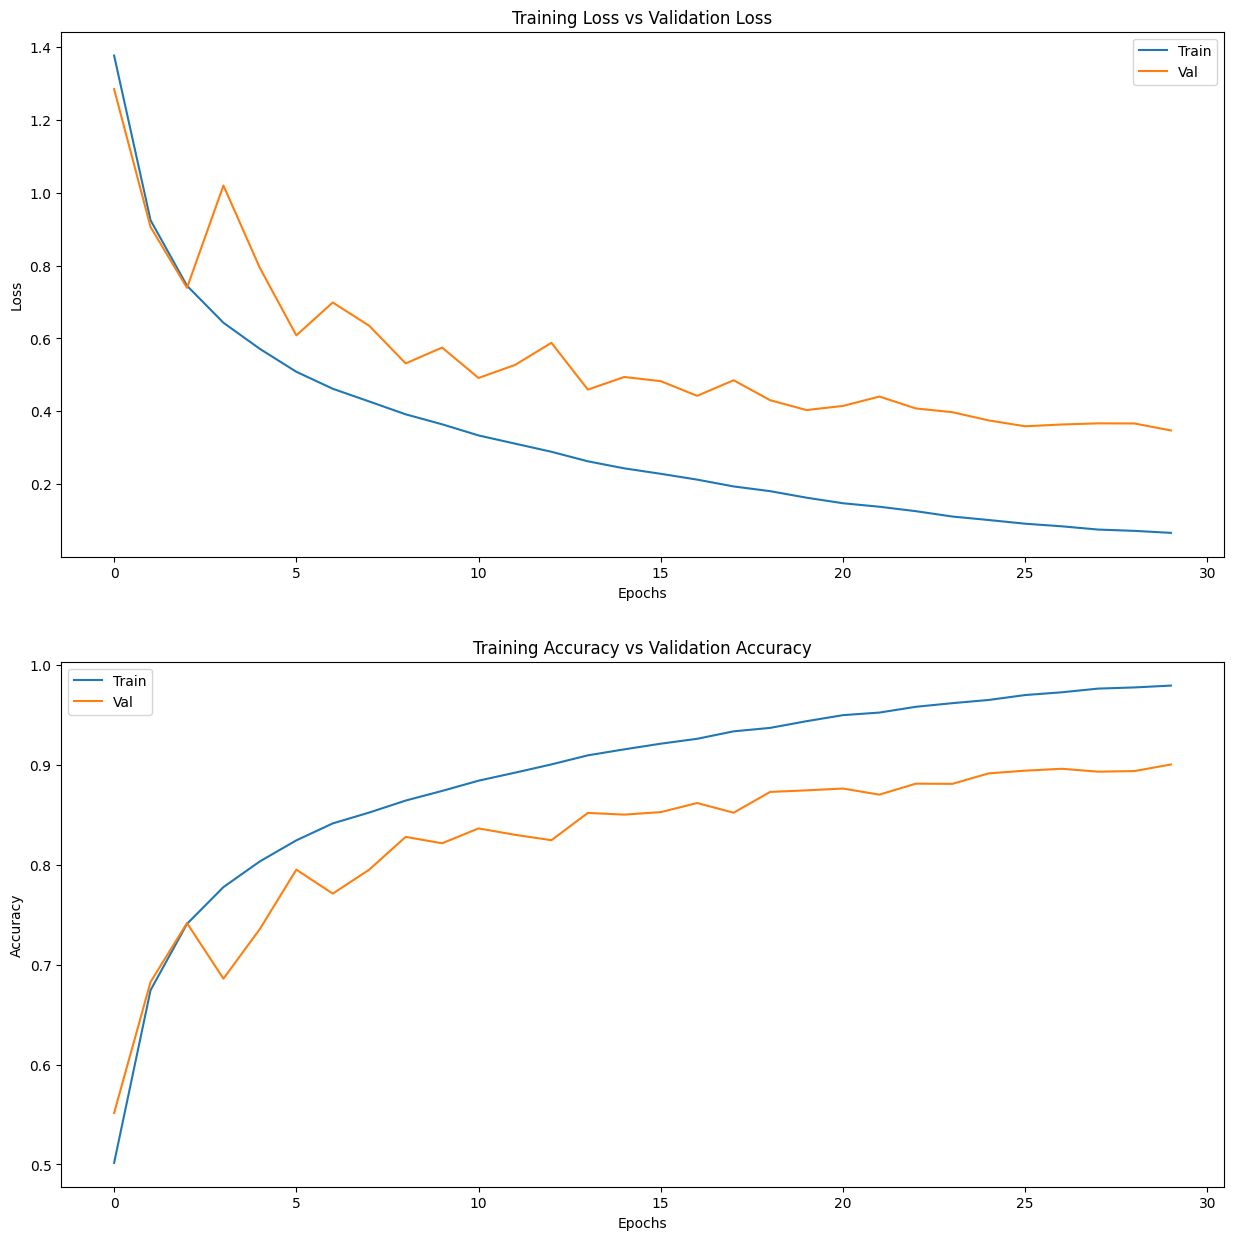

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])